In [57]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


import warnings
warnings.filterwarnings("ignore")

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 30*30*1 | 3*3 | 28*28*32
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)  # 30*30*32 | 3*3 | 28*28*64
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) # 30*30*32 | 3*3 | 28*28*64 
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(p=0.03)
        self.pool1 = nn.MaxPool2d(2, 2)  # 28*28*64 | 14*14*64
        self.conv31 = nn.Conv2d(32, 8, 1)  # 14*14*64| 1*1 | 14*14*8 

        self.conv4 = nn.Conv2d(8, 16, 3, padding=1)  # # 16*16*8  | 3*3 | 14*14*16
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 32, 3, padding=1) # 16*16*16 | 3*3 | 14*14*32
        self.bn5 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(p=0.07)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14*14*32 | 7*7*32
        self.conv51 = nn.Conv2d(32, 8, 1)  # 7*7*32 | 1*1 | 7*7*8

        self.conv6 = nn.Conv2d(8, 16, 3, padding=1)  # 9*9*8 | 3*3 | 7*7*16
        self.bn6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 32, 3, padding=1)  # 9*9*16 | 3*3 | 7*7*32
        self.bn7 = nn.BatchNorm2d(32)

        # alternative to below is nn.AvgPool2d(7) which gives a bit less accuracy
        self.gap1 =  nn.AdaptiveMaxPool2d((1,1))  #   7*7*32 | 1*1*32
        
        self.fc1 = nn.Linear(32, 10)  # 1*1*32 | 10

    def forward(self, x):
        # Adding drop out reduces the accuracy a bit
        x = self.conv31(self.pool1(self.bn3(F.relu(self.conv3(self.bn2(F.relu(self.conv2(self.bn1(F.relu(self.conv1(x)))))))))))  # self.dropout1()
        x = self.conv51(self.pool1(self.bn5(F.relu(self.conv5(self.bn4(F.relu(self.conv4(x))))))))  # self.dropout1()
        x = (self.bn7(F.relu(self.conv7(self.bn6(F.relu(self.conv6(x)))))))
        x = self.gap1(x)
        x = x.view(x.shape[0], -1)
        x = (self.fc1(x))
        return F.log_softmax(x)

In [60]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]           1,168
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 32, 28, 28]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             264
            Conv2d-9           [-1, 16, 14, 14]           1,168
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 32, 14, 14]           4,640
      BatchNorm2d-12           [-1, 32, 14, 14]              64
        MaxPool2d-13             [-1, 32, 7, 7]               0
           Conv2d-14              [-1, 

In [61]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [62]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph):
    model.train()
    train_loss = 0
    correct = 0
    # pbar = tqdm(train_loader)
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset), accuracy
        ))
    
    train_loss_graph.append(train_loss)
    train_accuracy_graph.append(accuracy)
    return train_loss_graph, train_accuracy_graph


def test(model, device, test_loader, test_loss_graph, test_accuracy_graph):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy
        ))
    test_loss_graph.append(test_loss)
    test_accuracy_graph.append(accuracy)
    return test_loss_graph, test_accuracy_graph


epoch number  1
Train set: Average loss: 0.0015, Accuracy: 56698/60000 (94.50%)
Test set: Average loss: 0.0608, Accuracy: 9804/10000 (98.04%)

epoch number  2
Train set: Average loss: 0.0004, Accuracy: 59180/60000 (98.63%)
Test set: Average loss: 0.0415, Accuracy: 9871/10000 (98.71%)

epoch number  3
Train set: Average loss: 0.0003, Accuracy: 59391/60000 (98.98%)
Test set: Average loss: 0.0319, Accuracy: 9907/10000 (99.07%)

epoch number  4
Train set: Average loss: 0.0002, Accuracy: 59498/60000 (99.16%)
Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

epoch number  5
Train set: Average loss: 0.0002, Accuracy: 59592/60000 (99.32%)
Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

epoch number  6
Train set: Average loss: 0.0001, Accuracy: 59647/60000 (99.41%)
Test set: Average loss: 0.0288, Accuracy: 9902/10000 (99.02%)

epoch number  7
Train set: Average loss: 0.0001, Accuracy: 59693/60000 (99.49%)
Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)


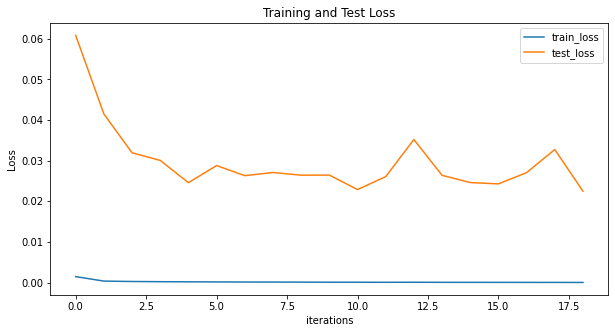

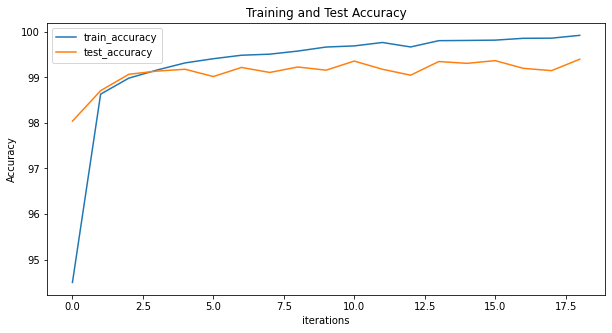

In [63]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_graph = []
train_accuracy_graph = []
test_loss_graph = []
test_accuracy_graph = []
for epoch in range(1, 20):
    print('epoch number ', epoch)
    train_loss_graph, train_accuracy_graph = train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph)
    test_loss_graph, test_accuracy_graph = test(model, device, test_loader, test_loss_graph, test_accuracy_graph)


import matplotlib.pyplot as plt

print(train_loss_graph, test_loss_graph)
print(train_accuracy_graph, test_accuracy_graph)
plt.figure(figsize=(10,5))
plt.title("Training and Test Loss")
plt.plot(train_loss_graph,label="train_loss")
plt.plot(test_loss_graph,label="test_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_graph,label="train_accuracy")
plt.plot(test_accuracy_graph,label="test_accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()